# Predicting veganism in the world - Karl Merisalu

## Importing libraries and data

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('multiTimeline.csv', skiprows=1)
df.head()

,Week,vegan: (Worldwide)
0,2014-06-01,31
1,2014-06-08,31
2,2014-06-15,31
3,2014-06-22,32
4,2014-06-29,32


In [5]:
df.columns

Index(['Week', 'vegan: (Worldwide)'], dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 2 columns):
Week                  261 non-null object
vegan: (Worldwide)    261 non-null int64
dtypes: int64(1), object(1)
memory usage: 4.2+ KB


## Adjusting data

In [7]:
# week column is an object but we need datetime, so converting it.
from datetime import datetime
df.Week = pd.to_datetime(df.Week)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 2 columns):
Week                  261 non-null datetime64[ns]
vegan: (Worldwide)    261 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 4.2 KB


In [8]:
# now need to set week as the index.
df.set_index('Week', inplace=True)
df.head()

,vegan: (Worldwide)
Week,
2014-06-01,31
2014-06-08,31
2014-06-15,31
2014-06-22,32
2014-06-29,32


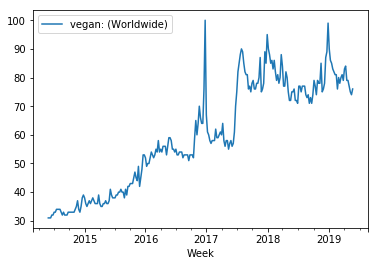

In [9]:
df.plot()

In [12]:
vegan = df['vegan: (Worldwide)']
vegan.head()

Week
2014-06-01    31
2014-06-08    31
2014-06-15    31
2014-06-22    32
2014-06-29    32
Name: vegan: (Worldwide), dtype: int64

In [13]:
# when not series we get below results
df.iloc[0]

vegan: (Worldwide)    31
Name: 2014-06-01 00:00:00, dtype: int64

In [14]:
# when series then get below results
vegan[0]

31

## Seasonal Decomposition

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [17]:
decomposition = seasonal_decompose(vegan, model='multiplicative', freq=52) # 52 is number of datapoints we have per period. this is 52 weeks in a year

In [18]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

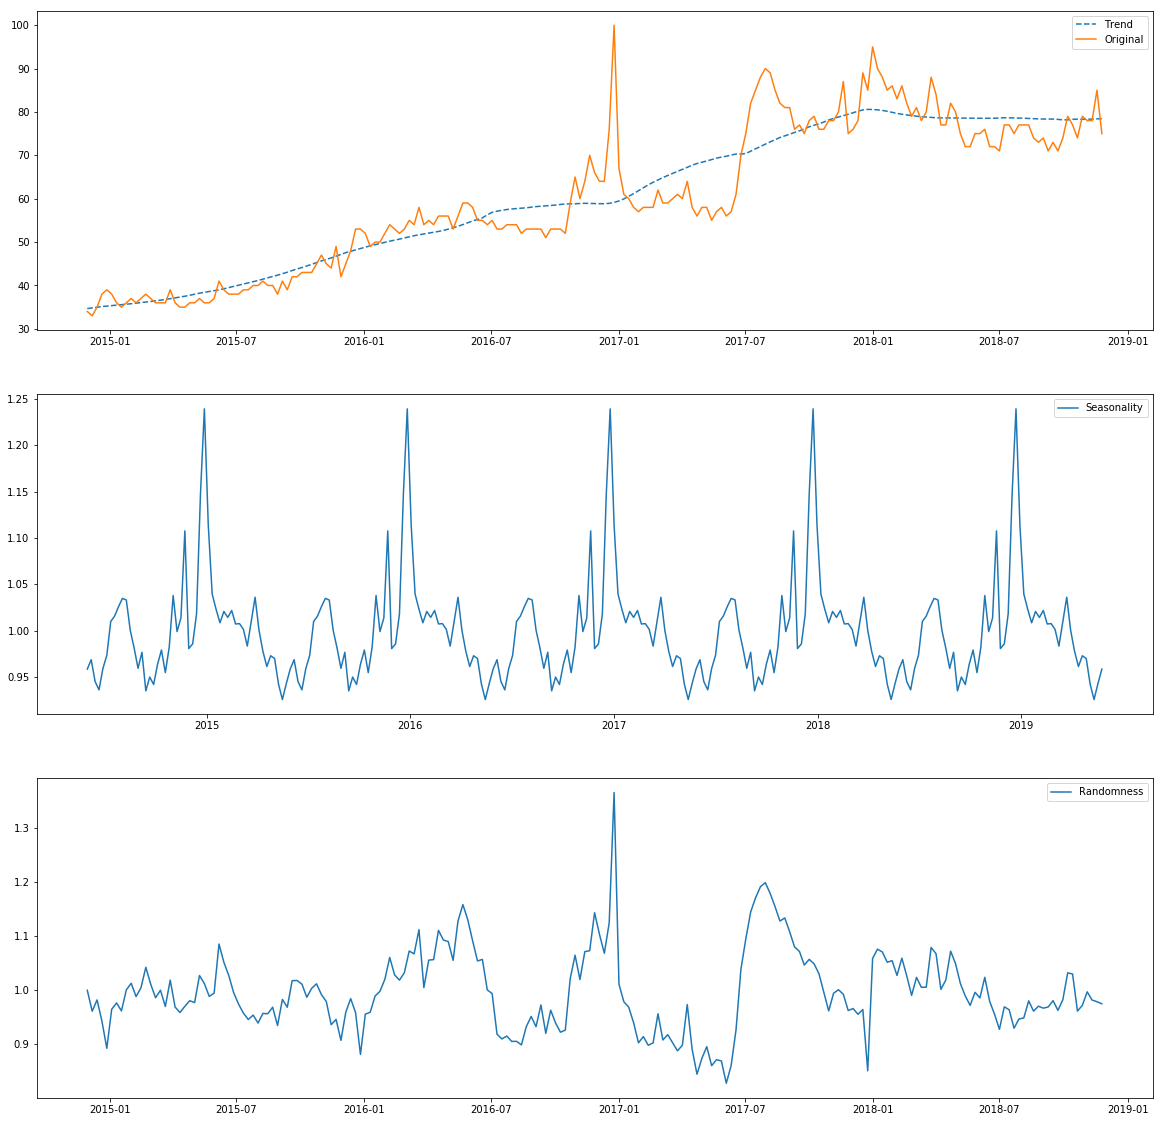

In [20]:
plt.figure(figsize=(20,20))
plt.figure(1)

plt.subplot(311) # 3 - number of plots, 1 - where it is on x axis, 1 - where it is on y axis
plt.plot(trend, linestyle='--', label='Trend')
plt.plot(trend*residual*seasonal, label='Original') # multiplying the parts to get the original model
plt.legend() # for adding legend

plt.subplot(312)
plt.plot(seasonal, label='Seasonality')
plt.legend()

plt.subplot(313)
plt.plot(residual, label='Randomness')
plt.legend() 

# ARIMA (p,d,q) model

AR (p) - how can i calculate what's today based on what happened yday <br>
I (d) - number of differencing <br>
MA (q) - Moving average <br>

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

(0, 50)

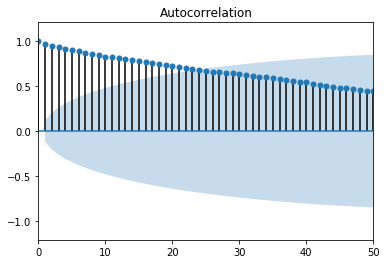

In [25]:
plot_acf(vegan)
plt.xlim(0,50)

In [26]:
diff = vegan.diff(1).dropna()

(0, 50)

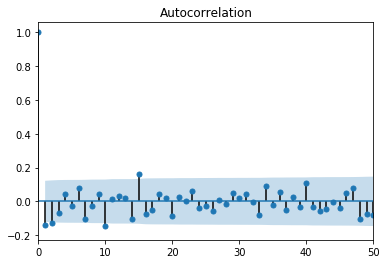

In [28]:
plot_acf(diff)
plt.xlim(0,50)

In [33]:
decomposition = seasonal_decompose(diff, model='additive', freq=52) # model is now additive because we have differentiated

In [34]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

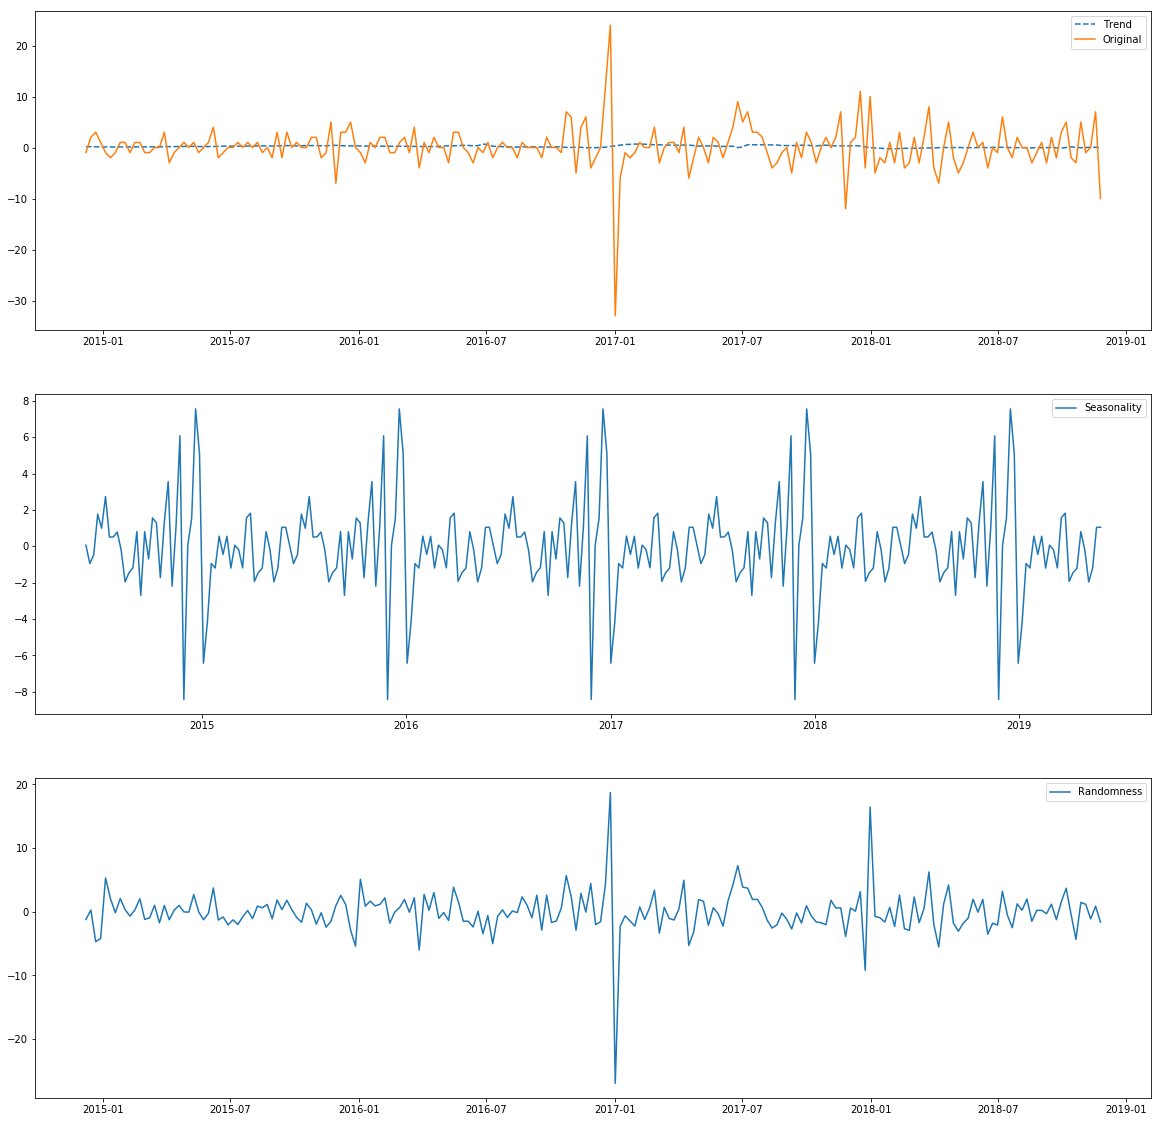

In [37]:
plt.figure(figsize=(20,20))
plt.figure(1)

plt.subplot(311) # 3 - number of plots, 1 - where it is on x axis, 1 - where it is on y axis
plt.plot(trend, linestyle='--', label='Trend')
plt.plot(trend+residual+seasonal, label='Original') # multiplying the parts to get the original model
plt.legend() # for adding legend

plt.subplot(312)
plt.plot(seasonal, label='Seasonality')
plt.legend()

plt.subplot(313)
plt.plot(residual, label='Randomness')
plt.legend() 

## d = 1

## time to find q

(0, 10)

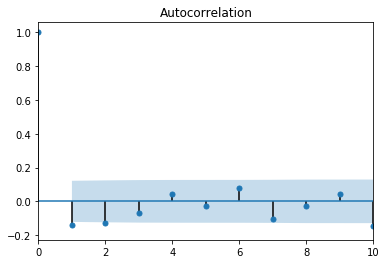

In [38]:
plot_acf(diff)
plt.xlim(0,10)

## q = 2 because further on lag is insignificant (related to moving average)

Repeating again after 10, but due to seasonality taken care of later

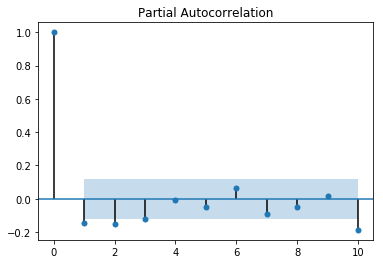

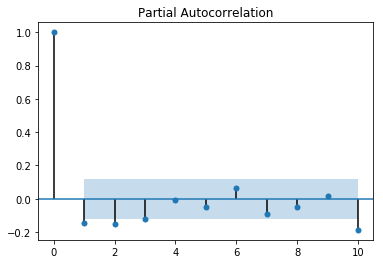

In [42]:
plot_pacf(diff, lags=10)

## p value is 3 because the chart shows 3 successive lags are significant (related to ar)
partial autoregressive means how t is affected to t-x

## ARIMA (3,1,2)

In [43]:
train = vegan[:'06-2018'].dropna()
test = vegan['06-2018':].dropna()

In [46]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [47]:
model = SARIMAX(train, order=(3,1,2), seasonal_order=(1,1,0,52), enforce_invertibility=False, enforce_stationarity=False)

T:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


In [48]:
results = model.fit()

In [49]:
predict = results.predict(start='06-2018', end='06-2019')

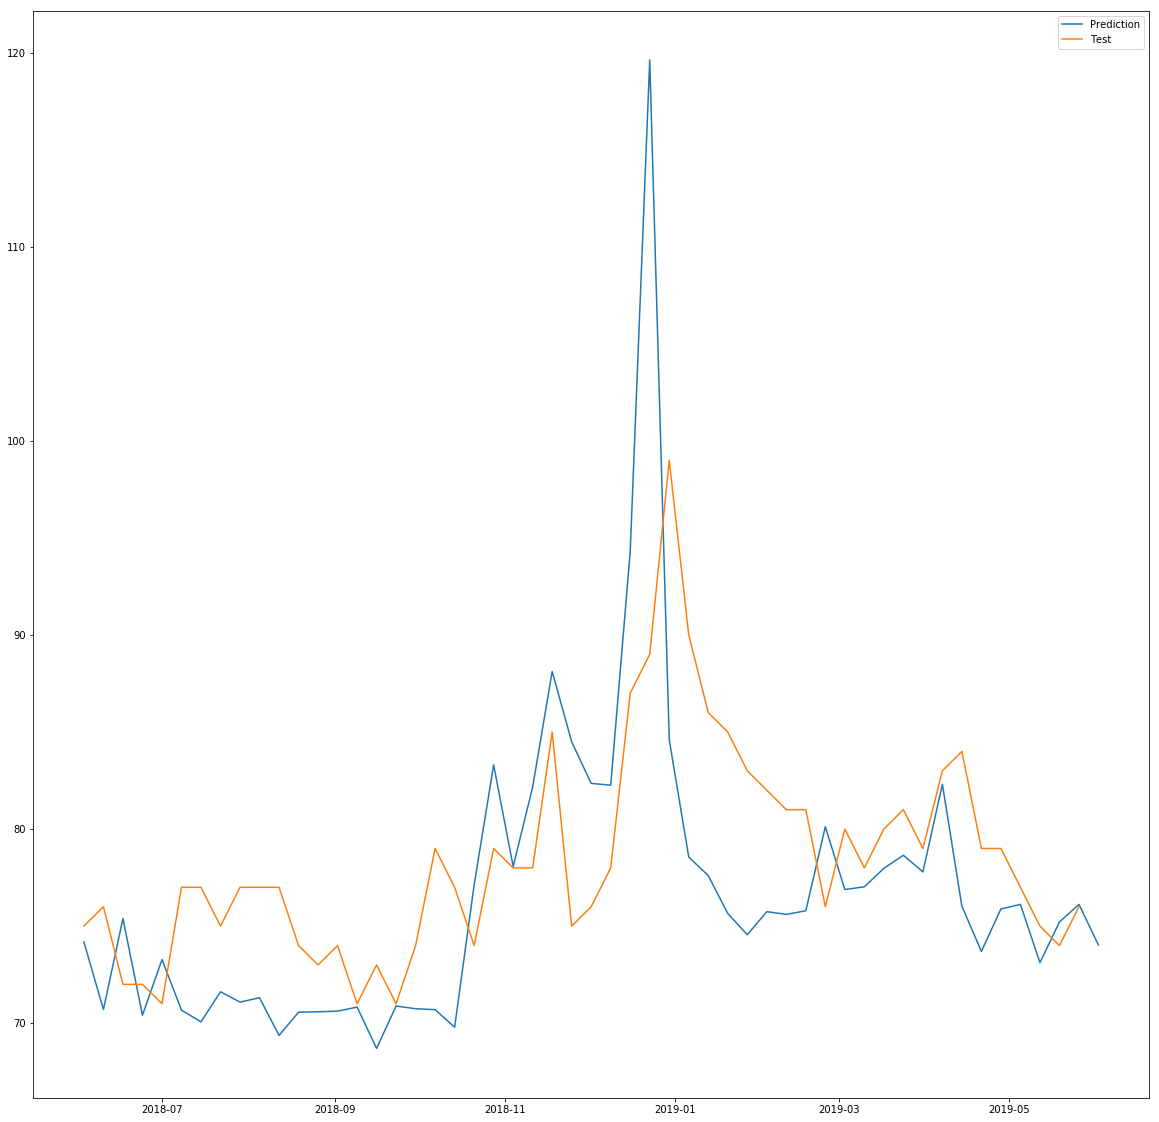

In [50]:
plt.figure(figsize=(20,20))
plt.figure(1)
plt.plot(predict, label='Prediction')
plt.plot(test, label='Test')
plt.legend()

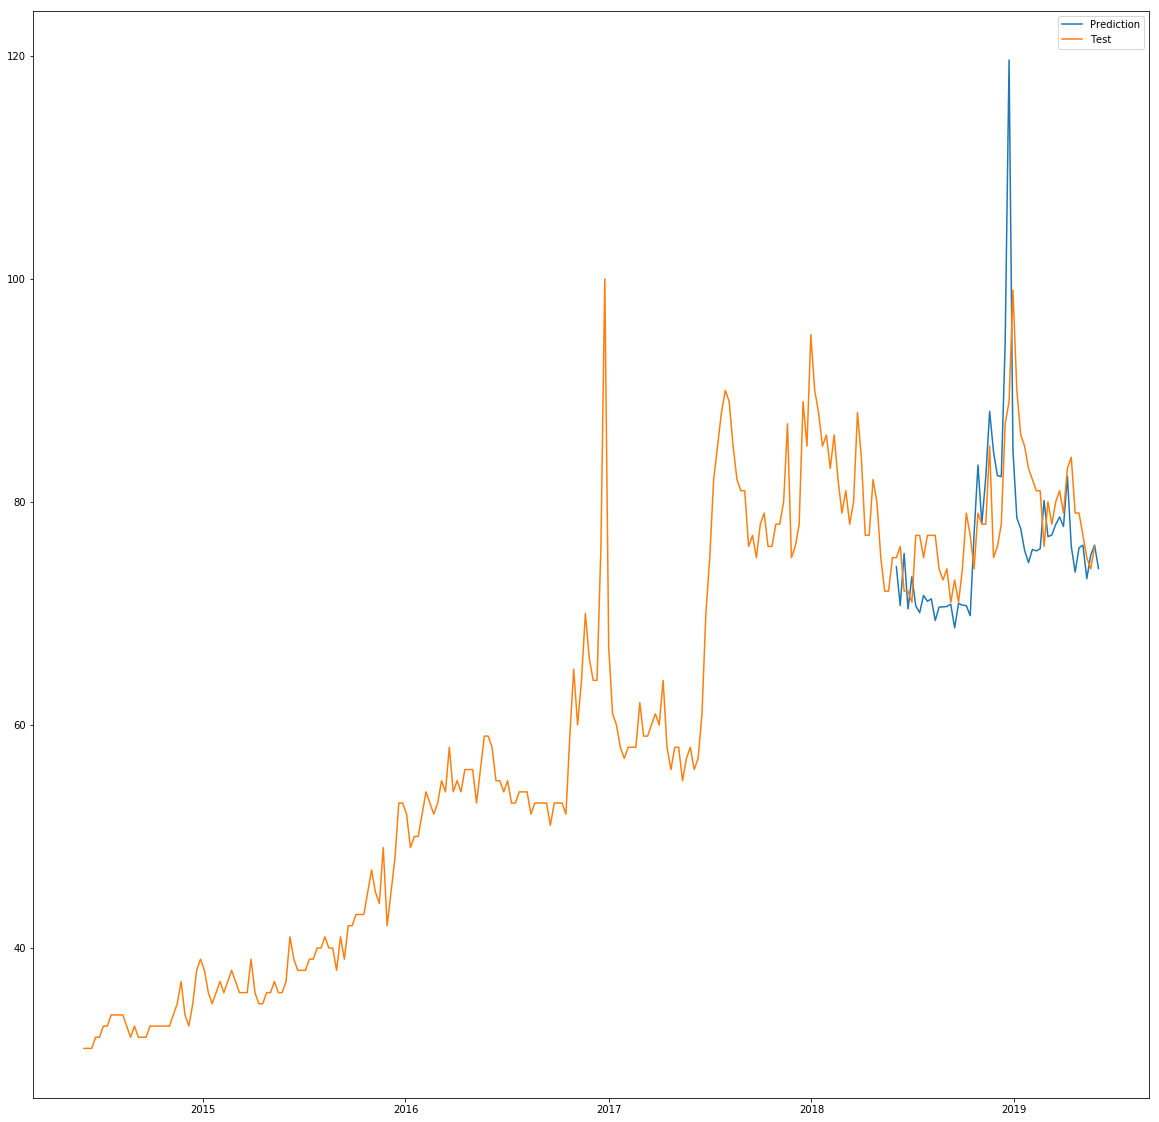

In [51]:
plt.figure(figsize=(20,20))
plt.figure(1)
plt.plot(predict, label='Prediction')
plt.plot(vegan, label='Test')
plt.legend()

In [52]:
full_predict = results.predict(start='06-2014', end='06-2019')[2:]

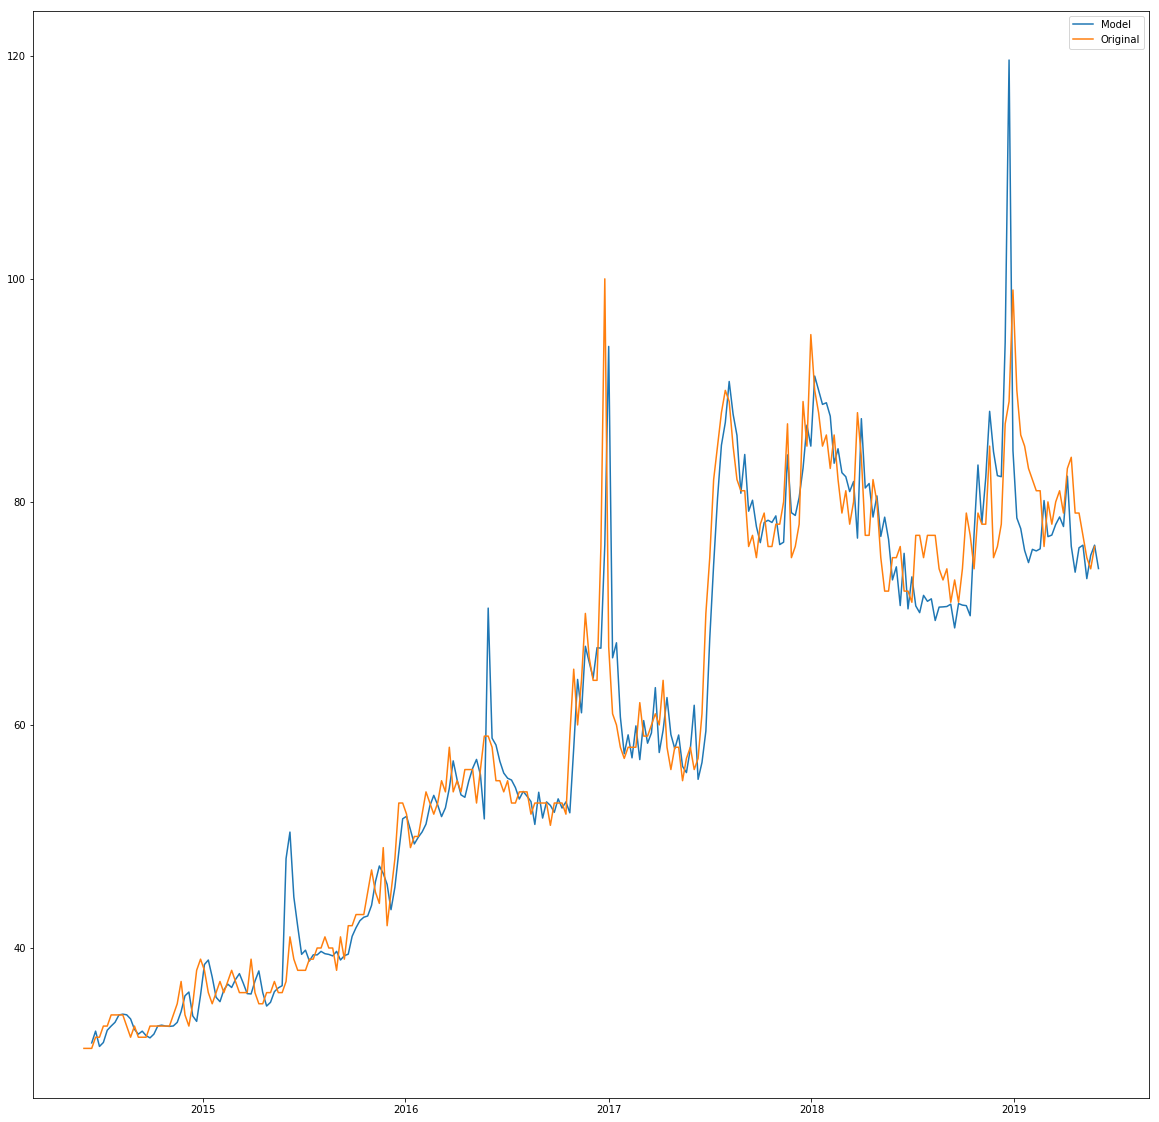

In [54]:
plt.figure(figsize=(20,20))
plt.figure(1)
plt.plot(full_predict, label='Model')
plt.plot(vegan, label='Original')
plt.legend()

In [55]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                 vegan: (Worldwide)   No. Observations:                  213
Model:             SARIMAX(3, 1, 2)x(1, 1, 0, 52)   Log Likelihood                -319.725
Date:                            Fri, 31 May 2019   AIC                            653.450
Time:                                    17:33:05   BIC                            672.028
Sample:                                06-01-2014   HQIC                           660.978
                                     - 06-24-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3105      0.700     -1.871      0.061      -2.683       0.062
ar.L2         -0.7842      0.713     -1.100      0.271      -2.181       0.613
ar.L3         -0.2309      0.174     -1.330      0.183      -0.571       0.109
ma.L1          1.1622      0.691      1.681      0.093      -0.193       2.517
ma.L2          0.4381      0.670      0.654      0.513      -0.876       1.752
ar.S.L52      -1.0469      0.094    -11.105      0.000      -1.232      -0.862
sigma2        25.8397      2.152     12.008      0.000      21.622      30.057
===================================================================================
Ljung-Box (Q):                       10.85   Jarque-Bera (JB):               450.83
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.36   Skew:                            -0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""